# Классификация лошадей 

https://medium.com/tensorflow2-mobilenets-a-pre-trained-multiclass/tensorflow2-mobilenets-a-pre-trained-multiclass-classifier-8a25d304c39dЁ

выбрать любую не VGG16 предобученную сеть: 
https://keras.io/api/applications/


1 модель на 1 пару студентов (но у каждого разные веса в модели)

MobileNet: 

https://habr.com/ru/post/352804/ 

https://arxiv.org/pdf/1704.04861.pdf 

https://habr.com/ru/post/467967/ 

https://izv.etu.ru/assets/files/6_2018_p027-032.pdf


* Создать сеть на основе предобученной сетки, обучить сеть распознованию пород лошадей
* Построить матрицу ошибок по исходной бд
* Вязть любые фото лошадей и протестировать свою сеть на
работоспособность
* Выведите картинки с правильными и неправильными метками (выборка)

In [ ]:
PATH = "../content/drive/My Drive/Нейронные сети 2_Модуль_2020/24112020/"

In [ ]:
import tensorflow as tf 
from keras.applications import MobileNet 
from keras.applications.mobilenet import preprocess_input, decode_predictions


import numpy as np 
import pandas as pd
from tensorflow import keras
from keras import layers, optimizers
from keras.models import Model, Sequential
from keras.utils.vis_utils import plot_model 
from keras.layers import Flatten, Dense, GlobalAveragePooling2D
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator

from sklearn.metrics import confusion_matrix
import seaborn as sns

import os, shutil
from  pathlib import Path 


import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import cv2 
import glob

# Загрузка данных 

In [ ]:
data_path = PATH+"koni/"

In [ ]:
horse_image_name = glob.glob(data_path + "*png")
len(horse_image_name)

563

In [ ]:
f = [x.with_suffix('').name for x in Path(data_path).glob('*')]

In [ ]:
f = [os.path.basename(x) for x in glob.glob(data_path+"/*")]
f

['03_032.png',
 '02_103.png',
 '01_096.png',
 '02_072.png',
 '03_019.png',
 '03_030.png',
 '02_002.png',
 '02_032.png',
 '02_028.png',
 '02_070.png',
 '03_015.png',
 '02_077.png',
 '03_002.png',
 '02_018.png',
 '03_020.png',
 '02_047.png',
 '02_062.png',
 '03_028.png',
 '02_104.png',
 '01_097.png',
 '03_029.png',
 '02_033.png',
 '02_016.png',
 '02_023.png',
 '02_025.png',
 '02_101.png',
 '02_090.png',
 '02_060.png',
 '02_096.png',
 '02_076.png',
 '03_008.png',
 '02_014.png',
 '03_027.png',
 '02_007.png',
 '02_067.png',
 '02_039.png',
 '02_105.png',
 '02_051.png',
 '02_063.png',
 '02_001.png',
 '01_100.png',
 '02_080.png',
 '03_010.png',
 '02_094.png',
 '02_037.png',
 '03_026.png',
 '02_095.png',
 '02_038.png',
 '02_102.png',
 '03_021.png',
 '02_054.png',
 '03_013.png',
 '02_057.png',
 '02_089.png',
 '02_088.png',
 '02_099.png',
 '02_029.png',
 '02_071.png',
 '02_053.png',
 '02_030.png',
 '02_064.png',
 '02_043.png',
 '02_021.png',
 '03_011.png',
 '02_027.png',
 '02_009.png',
 '01_090.p

In [ ]:
# Метки 
y = []
for pic in f: 
  if pic[:2] == '01':
    y.append('Akhal-Teke')
  elif pic[:2] == '02':
    y.append('Appaloosa')
  elif pic[:2] == '03':
    y.append('Orlov Trotter')
  elif pic[:2] == '04':
    y.append('Vladimir Heavy Draft')
  elif pic[:2] == '05':
    y.append('Percheron')
  elif pic[:2] == '06':
    y.append('Arabian')
  elif pic[:2] == '07':
    y.append('Friesian')
  else: 
    print(pic)    

In [ ]:
len(f)

563

In [ ]:
len(y)

563

In [ ]:
df = pd.DataFrame({'img_path': f,
                   'class': y})
df = df.sort_values(by=['img_path'])
df = df.reset_index(drop=True)
df.head()

,img_path,class
0,01_001.png,Akhal-Teke
1,01_002.png,Akhal-Teke
2,01_003.png,Akhal-Teke
3,01_004.png,Akhal-Teke
4,01_005.png,Akhal-Teke


In [ ]:
df.tail()

,img_path,class
558,07_050.png,Friesian
559,07_051.png,Friesian
560,07_052.png,Friesian
561,07_053.png,Friesian
562,07_054.png,Friesian


Проверим баланс классов

In [ ]:
df['class'].value_counts()

Orlov Trotter           107
Appaloosa               105
Akhal-Teke              103
Arabian                 101
Percheron                56
Friesian                 54
Vladimir Heavy Draft     37
Name: class, dtype: int64

In [ ]:
classes = [i for i in df['class'].unique()]
classes 

['Akhal-Teke',
 'Appaloosa',
 'Orlov Trotter',
 'Vladimir Heavy Draft',
 'Percheron',
 'Arabian',
 'Friesian']

In [ ]:
classes_balance = pd.DataFrame({'cnt': [i for i in df['class'].value_counts()]}, index=classes)
classes_balance

,cnt
Akhal-Teke,107
Appaloosa,105
Orlov Trotter,103
Vladimir Heavy Draft,101
Percheron,56
Arabian,54
Friesian,37


# Заргрузка данных и разбивка на train и valid 

In [ ]:
# Создаем папку картинок с разделением на train valid по классам
base_dir = PATH+'koni_train_valid/'
os.mkdir(base_dir)

In [ ]:
train_dir = os.path.join(base_dir, 'training')
os.mkdir(train_dir)

In [ ]:
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)

In [ ]:
def data_load_for_class(list_imgs_paths, from_dir, to_dir): 
  # Создаем папку для класса
  os.mkdir(to_dir)

   # Загрузка картинок данного класса в свою папку
  for j in list_imgs_paths:
    src = os.path.join(from_dir, j) 
    dst = os.path.join(to_dir, j) 
    shutil.copyfile(src, dst)

In [ ]:
## от каждого класса возьмем 20% картинок для валидации
for i in classes:
  # Кол-во картинок в классе
  # cnt_in_class = classes_balance[classes_balance['index']==i]['cnt']

  # Список картинок данного класса
  class_img_paths = list(df[df['class']==i]['img_path'])

  ###### train #####
  idx_tr = int(round(len(class_img_paths)*0.8,0))
  class_img_paths_train = class_img_paths[:idx_tr] # список картинок класса 

  # картинка из исходного набора данных 
  from_dir = PATH+'koni/'
  # перемещение в новую папку класса 
  to_dir_tr = PATH+'koni_train_valid/'+'training/'+i

  data_load_for_class(class_img_paths_train, from_dir, to_dir_tr)

  ###### valid ######
  class_img_paths_valid = class_img_paths[idx_tr:] # список картинок класса 

  # перемещение в новую папку класса
  to_dir_val = PATH+'koni_train_valid/'+'validation/'+i

  data_load_for_class(class_img_paths_valid, from_dir, to_dir_val)

In [ ]:
# Проверим кол-во картинок
data_type_list = ['training', 'validation']

for i in classes:
  for j in data_type_list: 
    to_dir = PATH+'koni_train_valid/'+j+'/'+i
    print('Кол-во картинок класса '+ i +' '+j+': ', len(os.listdir(to_dir)))

Кол-во картинок класса Orlov Trotter training:  86
Кол-во картинок класса Orlov Trotter validation:  21
Кол-во картинок класса Appaloosa training:  84
Кол-во картинок класса Appaloosa validation:  21
Кол-во картинок класса Akhal-Teke training:  82
Кол-во картинок класса Akhal-Teke validation:  21
Кол-во картинок класса Arabian training:  81
Кол-во картинок класса Arabian validation:  20
Кол-во картинок класса Percheron training:  45
Кол-во картинок класса Percheron validation:  11
Кол-во картинок класса Friesian training:  43
Кол-во картинок класса Friesian validation:  11
Кол-во картинок класса Vladimir Heavy Draft training:  30
Кол-во картинок класса Vladimir Heavy Draft validation:  7


## Подготовка данных

In [ ]:
original_dataset_dir = PATH+'koni/'
original_dataset_dir

'../content/drive/My Drive/Нейронные сети 2_Модуль_2020/24112020/koni/'

In [ ]:
base_dir = PATH+'koni_train_valid/'
# os.mkdir(base_dir)

In [ ]:
train_dir = os.path.join(base_dir, 'training')
# os.mkdir(train_dir)

In [ ]:
validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)

In [ ]:
train_datagen = ImageDataGenerator(rotation_range=270, 
                             width_shift_range=0.1, 
                             zoom_range=0.15,
                             rescale=1/255,
                             validation_split = 0.2)

test_datagen = ImageDataGenerator(rotation_range=270, 
                             width_shift_range=0.1, 
                             zoom_range=0.15,
                             rescale=1/255,
                             validation_split = 0.2)

In [ ]:
train_generator = train_datagen.flow_from_directory(
                    train_dir, # Целевой каталог 
                    target_size=(224, 224), 
                    batch_size=20, 
                    class_mode='categorical') 

Found 451 images belonging to 7 classes.


In [ ]:
validation_generator = test_datagen.flow_from_directory( 
                    validation_dir,
                    target_size=(224, 224), 
                    batch_size=20,
                    class_mode='categorical')

Found 112 images belonging to 7 classes.


In [ ]:
dic_class_tr = train_generator.class_indices
dic_class_val = validation_generator.class_indices

In [ ]:
train_generator.class_indices

{'Akhal-Teke': 0,
 'Appaloosa': 1,
 'Arabian': 2,
 'Friesian': 3,
 'Orlov Trotter': 4,
 'Percheron': 5,
 'Vladimir Heavy Draft': 6}

In [ ]:
validation_generator.class_indices

{'Akhal-Teke': 0,
 'Appaloosa': 1,
 'Arabian': 2,
 'Friesian': 3,
 'Orlov Trotter': 4,
 'Percheron': 5,
 'Vladimir Heavy Draft': 6}

In [ ]:
classes = [i for i in validation_generator.class_indices.keys()]
classes

['Akhal-Teke',
 'Appaloosa',
 'Arabian',
 'Friesian',
 'Orlov Trotter',
 'Percheron',
 'Vladimir Heavy Draft']

## Построение сети

In [ ]:
model = MobileNet(weights='imagenet', 
                  include_top=True, # подключаем классификатор
                  input_shape=(224, 224, 3))

#### Train data

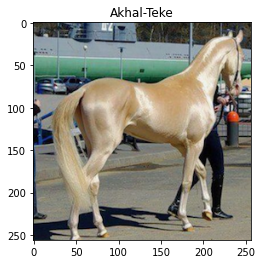

40960/35363 [==================================] - 0s 0us/step
sorrel (83.68%)


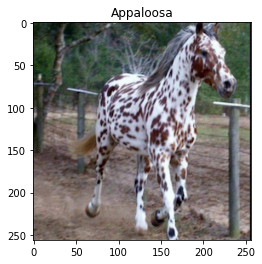

dalmatian (91.01%)


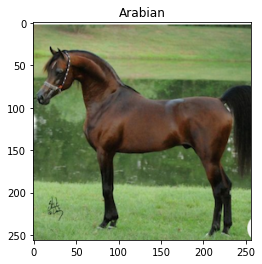

sorrel (97.43%)


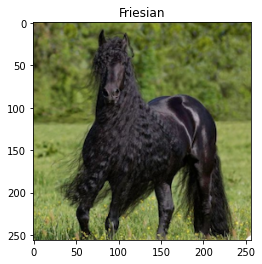

standard_poodle (35.82%)


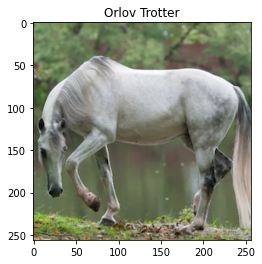

bighorn (18.31%)


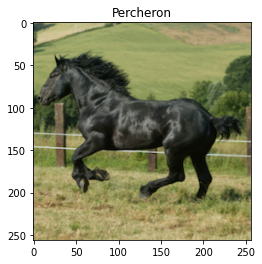

Great_Dane (30.37%)


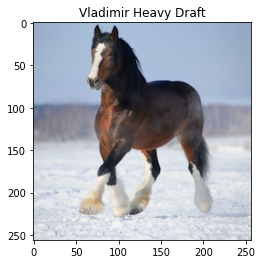

Great_Dane (22.04%)


In [ ]:
for i in classes:
  j = 'training' # из train data посмотрим по 1 примеру 
  to_dir = PATH+'koni_train_valid/'+j+'/'+i
  
  files_list = os.listdir(to_dir)

  k = 0 # по 1 примеру из каждого класса 
  for file_name in files_list:
    image = load_img(to_dir+'/'+file_name, target_size=(224, 224))
    img = mpimg.imread(to_dir+'/'+file_name)
    imgplot = plt.imshow(img)
    plt.title(i)
    plt.show()

    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y = model.predict(image)
    
    label = decode_predictions(y)
    label = label[0][0]
    
    print('%s (%.2f%%)' % (label[1], label[2]*100))

    k += 1

    if k == 1: 
      break


использование в лоб: сеть плохо распознает классы. Путает с собаками

#### valid data

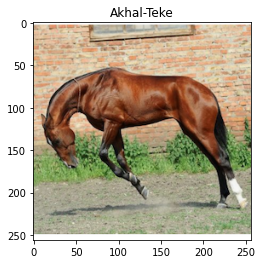

sorrel (85.03%)


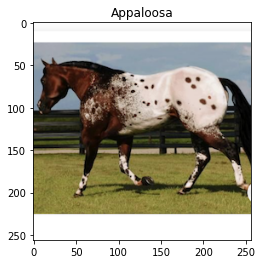

sorrel (64.36%)


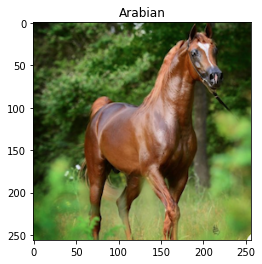

sorrel (97.90%)


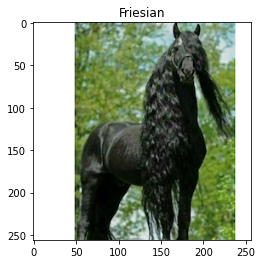

giant_schnauzer (80.66%)


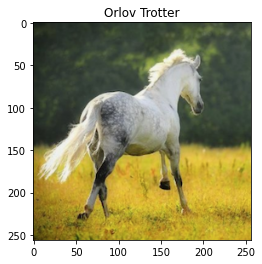

sorrel (20.64%)


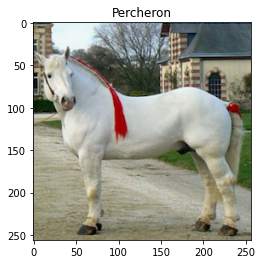

Great_Dane (36.52%)


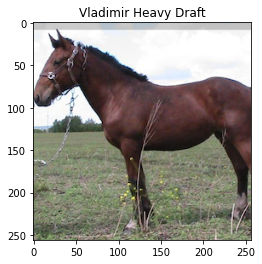

sorrel (99.97%)


In [ ]:
for i in classes:
  j = 'validation' # из train data посмотрим по 1 примеру 
  to_dir = PATH+'koni_train_valid/'+j+'/'+i

  files_list = os.listdir(to_dir)

  k = 0 # по 1 примеру из каждого класса 
  for file_name in files_list:
    image = load_img(to_dir+'/'+file_name, target_size=(224, 224))
    img = mpimg.imread(to_dir+'/'+file_name)
    imgplot = plt.imshow(img)
    plt.title(i)
    plt.show()

    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y = model.predict(image)
    
    label = decode_predictions(y)
    label = label[0][0]
    
    print('%s (%.2f%%)' % (label[1], label[2]*100))

    k += 1

    if k == 1: 
      break


На валидационных данных также плохо

## Выделение признаков

In [ ]:
# Создание экземпляра сверточной основы VGG16
conv_base = MobileNet(weights='imagenet', 
              include_top=False, # отключаем классификатор, будет добавлен свой
              input_shape=(224, 224, 3))

In [ ]:
conv_base.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

### Выделение признаков с расширением данных

In [ ]:
# Добавить conv_base в модель Sequential как обычный слой
model = Sequential()
model.add(conv_base)
model.add(Flatten()) 
model.add(Dense(1024, activation='relu')) 
model.add(Dense(512, activation='relu')) 
model.add(Dense(7, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 7, 7, 1024)        3228864   
_________________________________________________________________
flatten_2 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              51381248  
_________________________________________________________________
dense_7 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_8 (Dense)              (None, 7)                 3591      
Total params: 55,138,503
Trainable params: 55,116,615
Non-trainable params: 21,888
_________________________________________________________________


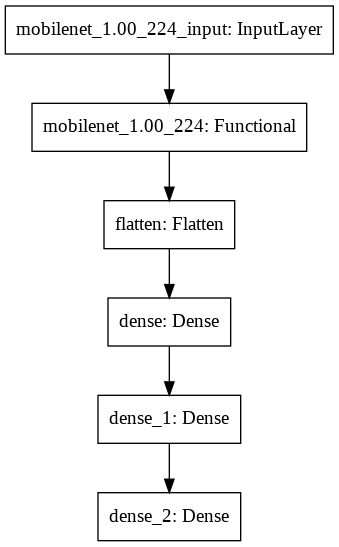

In [ ]:
plot_model(model, to_file=PATH+'model_with_Mobile_layer.png')

In [ ]:
# Заморозим сверточную основу, чтобы предотвратить изменение весовых коэффициентов в ней в процессе обучения. 
print('Кол-во слоев для обучения перед заморозкой:', len(model.trainable_weights))
conv_base.trainable = False
print('Кол-во слоев для обучения после заморозки:', len(model.trainable_weights)) 

Кол-во слоев для обучения перед заморозкой: 87
Кол-во слоев для обучения после заморозки: 6


In [ ]:
# Введем callback
callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='val_acc', patience=5),
        keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.1, patience=10)  
]

In [ ]:
# Загрузка Обученной нейронной сети
# model = keras.models.load_model(PATH+'model.h5')

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5), #SGD(lr=2e-5), точность 0.2 #Adam(lr=2e-5), #0.76  -- 0.75
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=10,
                    epochs=12, # Нельзя, чтобы steps_per_epoch*epochs > validation_data.shape[0]
                    validation_data=validation_generator,
                    validation_steps=5,
                    callbacks=callbacks_list)

Epoch 1/12
10/10 [==============================] - 19s 2s/step - loss: 1.0522 - acc: 0.7200 - val_loss: 1.4517 - val_acc: 0.5800
Epoch 2/12
10/10 [==============================] - 17s 2s/step - loss: 0.9045 - acc: 0.7330 - val_loss: 1.1363 - val_acc: 0.6100
Epoch 3/12
10/10 [==============================] - 17s 2s/step - loss: 0.7372 - acc: 0.7750 - val_loss: 1.0347 - val_acc: 0.6100
Epoch 4/12
10/10 [==============================] - 17s 2s/step - loss: 0.5356 - acc: 0.8168 - val_loss: 1.1130 - val_acc: 0.6500
Epoch 5/12
10/10 [==============================] - 17s 2s/step - loss: 0.5778 - acc: 0.8272 - val_loss: 1.4570 - val_acc: 0.5500
Epoch 6/12
10/10 [==============================] - 17s 2s/step - loss: 0.6129 - acc: 0.7900 - val_loss: 0.9834 - val_acc: 0.6500
Epoch 7/12
10/10 [==============================] - 17s 2s/step - loss: 0.5395 - acc: 0.8050 - val_loss: 1.1710 - val_acc: 0.6500
Epoch 8/12
10/10 [==============================] - 17s 2s/step - loss: 0.4865 - acc: 0.83

In [ ]:
# Сохранение Обученной нейронной сети
# keras.models.save_model(model,PATH+'model.h5')

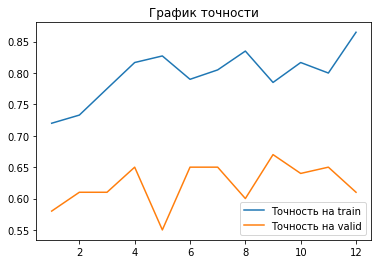

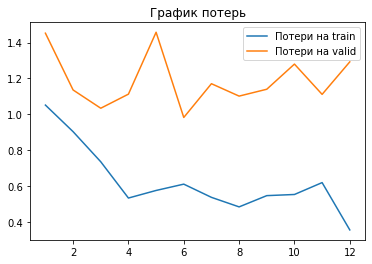

In [ ]:
# Графики работы
acc = history.history['acc']
val_acc = history.history['val_acc'] 
loss = history.history['loss'] 
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, label='Точность на train') 
plt.plot(epochs, val_acc, label='Точность на valid') 
plt.title('График точности') 
plt.legend()
plt.figure()
plt.plot(epochs, loss, label='Потери на train') 
plt.plot(epochs, val_loss, label='Потери на valid') 
plt.title('График потерь')
plt.legend()
plt.show()

#### Train data

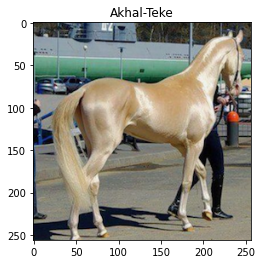

Akhal-Teke (91.97%)


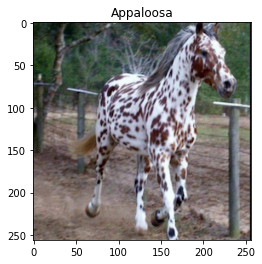

Appaloosa (100.00%)


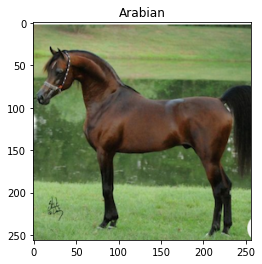

Arabian (95.57%)


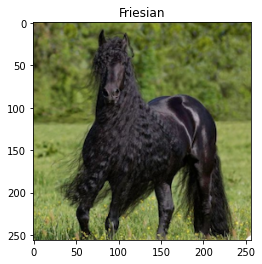

Friesian (91.43%)


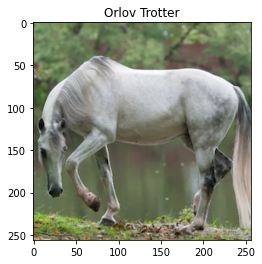

Orlov Trotter (54.04%)


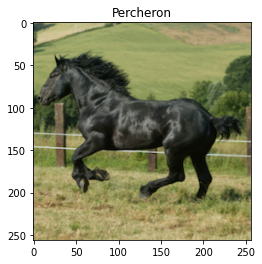

Arabian (66.88%)


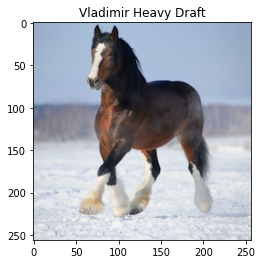

Vladimir Heavy Draft (96.25%)


In [ ]:
values_tr = [i for i in dic_class_tr.keys()] 

for i in classes:
  j = 'training' # из train data посмотрим по 1 примеру 
  to_dir = PATH+'koni_train_valid/'+j+'/'+i

  files_list = os.listdir(to_dir)

  k = 0 # по 1 примеру из каждого класса 
  for file_name in files_list:
    image = load_img(to_dir+'/'+file_name, target_size=(224, 224))
    img = mpimg.imread(to_dir+'/'+file_name)
    imgplot = plt.imshow(img)
    plt.title(i)
    plt.show()

    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y = model.predict(image)
    
    label = np.argmax(y[0]) #decode_predictions(y)
    label_name = values_tr[label]
    label_prob = y[0][label]
    
    print('%s (%.2f%%)' % (label_name, label_prob*100))

    k += 1

    if k == 1: 
      break


Лучше - сеть путает Percheron и Arabian

In [ ]:
train_loss, train_acc = model.evaluate_generator(train_generator, steps=10) 
print('train acc:', train_acc)

train acc: 0.8500000238418579


#### матрица ошибок 

In [ ]:
def get_confusion_matrix(model, data_type, dic_class): 

  values = [i for i in dic_class.keys()] 
  actual = []
  predict = []

  for i in classes:

    to_dir = PATH+'koni_train_valid/'+data_type+'/'+i

    files_list = os.listdir(to_dir)

    k = 0 # по 1 примеру из каждого класса 
    for file_name in files_list:
      image = load_img(to_dir+'/'+file_name, target_size=(224, 224))

      image = img_to_array(image)
      image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
      image = preprocess_input(image)
      y = model.predict(image)
      
      label = np.argmax(y[0]) 
      label_name = values[label]
      label_prob = y[0][label]

      actual.append(i)
      predict.append(label_name)
      #print('%s (%.2f%%)' % (label_name, label_prob*100))
  
  df = pd.DataFrame({'actual': actual, 'preds': predict})

  return df

In [ ]:
cm = get_confusion_matrix(model, 'training', dic_class_tr)

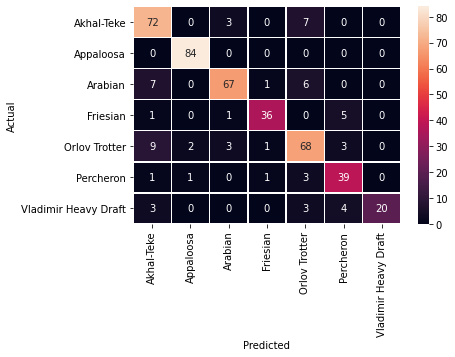

In [ ]:
confusion_matrix = pd.crosstab(cm['actual'], cm['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5)

Классификация довольно успешная

#### valid data

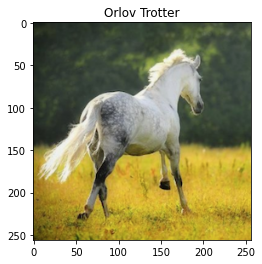

Orlov Trotter (94.65%)


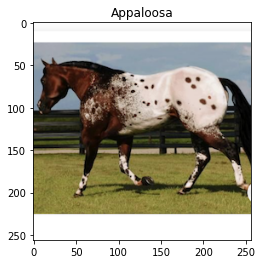

Appaloosa (99.82%)


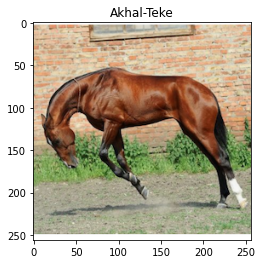

Akhal-Teke (78.05%)


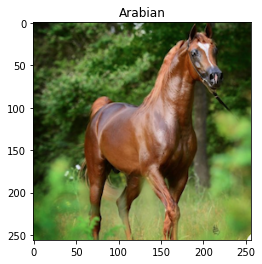

Arabian (67.40%)


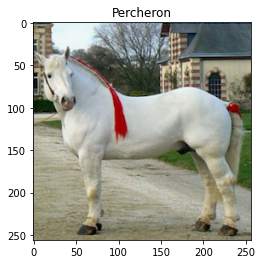

Orlov Trotter (61.56%)


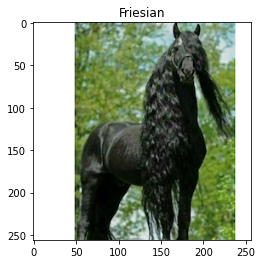

Friesian (95.84%)


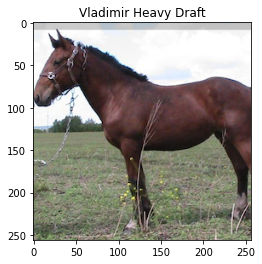

Akhal-Teke (90.31%)


In [ ]:
values_val = [i for i in dic_class_val.keys()] 

for i in classes:
  j = 'validation' # из train data посмотрим по 1 примеру 
  to_dir = PATH+'koni_train_valid/'+j+'/'+i

  files_list = os.listdir(to_dir)

  k = 0 # по 1 примеру из каждого класса 
  for file_name in files_list:
    image = load_img(to_dir+'/'+file_name, target_size=(224, 224))
    img = mpimg.imread(to_dir+'/'+file_name)
    imgplot = plt.imshow(img)
    plt.title(i)
    plt.show()

    image = img_to_array(image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    image = preprocess_input(image)
    y = model.predict(image)
    
    label = np.argmax(y[0]) #decode_predictions(y)
    label_name = values_val[label]
    label_prob = y[0][label]
    
    print('%s (%.2f%%)' % (label_name, label_prob*100))

    k += 1

    if k == 1: 
      break



На валидационных данных хуже. Последний класс ошибочен

In [ ]:
valid_loss, valid_acc = model.evaluate_generator(validation_generator, steps=5) 
print('valid acc:', valid_acc)

valid acc: 0.6299999952316284


#### матрица ошибок 

In [ ]:
cm_val = get_confusion_matrix(model, 'validation', dic_class_val)

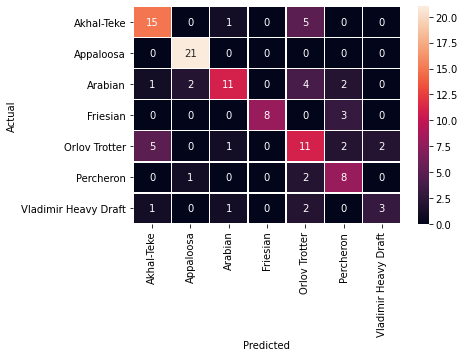

In [ ]:
confusion_matrix = pd.crosstab(cm_val['actual'], cm_val['preds'], rownames=['Actual'], colnames=['Predicted'], margins = False)
sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=0.5)

на валидации хуже. Путаются классы Vladimir Heavy Draft с другими

Orlov Trotter и Akhal Tekke сложнее всего различать, так как оба вида лошадей преимущественно белого цвета

#### Проверка на внешних данных

In [ ]:
def get_predict(image_path):
    values_tr = [i for i in dic_class_tr.keys()]

    title_name = image_path
    image_path = PATH+image_path
    image = load_img(image_path, target_size=(224, 224))
    imgplot = plt.imshow(image)
    plt.title(title_name)
    plt.show()

    image = img_to_array(image)
    image = image.reshape((1, image.shape[0],
                           image.shape[1], 
                           image.shape[2]))
    image = preprocess_input(image)
    y = model.predict(image)
    
    label = np.argmax(y[0]) #decode_predictions(y)
    label_name = values_tr[label]
    label_prob = y[0][label]
    
    print('%s (%.2f%%)' % (label_name, label_prob*100))


In [ ]:
PATH

'../content/drive/My Drive/Нейронные сети 2_Модуль_2020/24112020/'

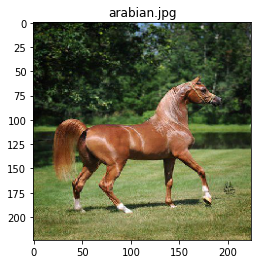

Arabian (84.36%)


In [ ]:
get_predict('arabian.jpg')

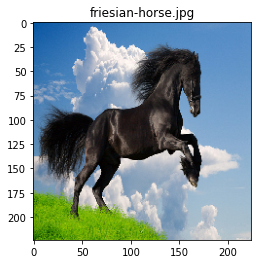

Friesian (95.24%)


In [ ]:
get_predict('friesian-horse.jpg')

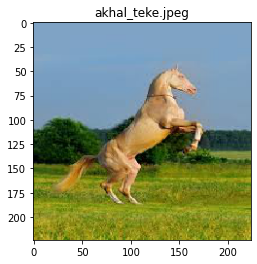

Orlov Trotter (85.25%)


In [ ]:
get_predict('akhal_teke.jpeg')

для наглядности, что белые лошади из других классов сеть не различает